## Performance analyse of PET with different values of D_PET and N_GNN

This notebook analyzes the performance of PET varing the values of such hyperparameters as `N_GNN` and `D_PET` (`HEAD_N_NEURONS`, `TRANSFORMER_D_MODEL`) with the focus on evaluating the mean absolute error (MAE) and interference times.

In [55]:
from matplotlib import pyplot as plt
import os
import re
import numpy as np
import pickle

Helper functions

In [56]:
def sort_key(name):
    """
    Sorts folder names based on numeric values within the names
    """
    return [int(text) if text.isdigit() else text for text in re.split(r"(\d+)", name)]

In [57]:
def get_best_maes(folders, keys):
    """
    Extract the value of best MAE from the summary.txt
    """
    target_phrase = "best val mae in energies per structure:"
    best_maes = {}

    for index, folder in enumerate(folders):
        path = os.path.join(folder, "results")
        attempts = sorted(os.listdir(path), key=sort_key)

        if not attempts:
            print(f"No result folders found in {path}")
            continue

        last_folder = attempts[-1]
        summary_file_path = os.path.join(path, last_folder, "summary.txt")

        if not os.path.isfile(summary_file_path):
            print(f"File {summary_file_path} not found")
            continue

        with open(summary_file_path, "r") as file:
            for line in file:
                if target_phrase in line:
                    best_maes[str(keys[index])] = float(
                        line.split(target_phrase)[-1].split()[0]
                    )

    return best_maes

### MAE vs Number of GNN Layers

MAE is analysed against the number of GNN layers with a fixed dimensionality (`HEAD_N_NEURONS`, `TRANSFORMER_D_MODEL`) of the PET

In [58]:
def plot(x_values, y_values_list, labels, title, xlabel, ylabel):
    plt.figure(figsize=(16, 9))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    for y_values, label in zip(y_values_list, labels):
        plt.plot(x_values, y_values, label=label, marker='o')

    for i, y_values in enumerate(y_values_list):
        for x, y in zip(x_values, y_values):
            # plt.annotate(
            #     f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0, 10), ha="center"
            # )
            plt.annotate(
                f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0, 10), ha="center",
                fontsize=8
            )


    plt.grid(True)
    plt.legend()
    plt.show()

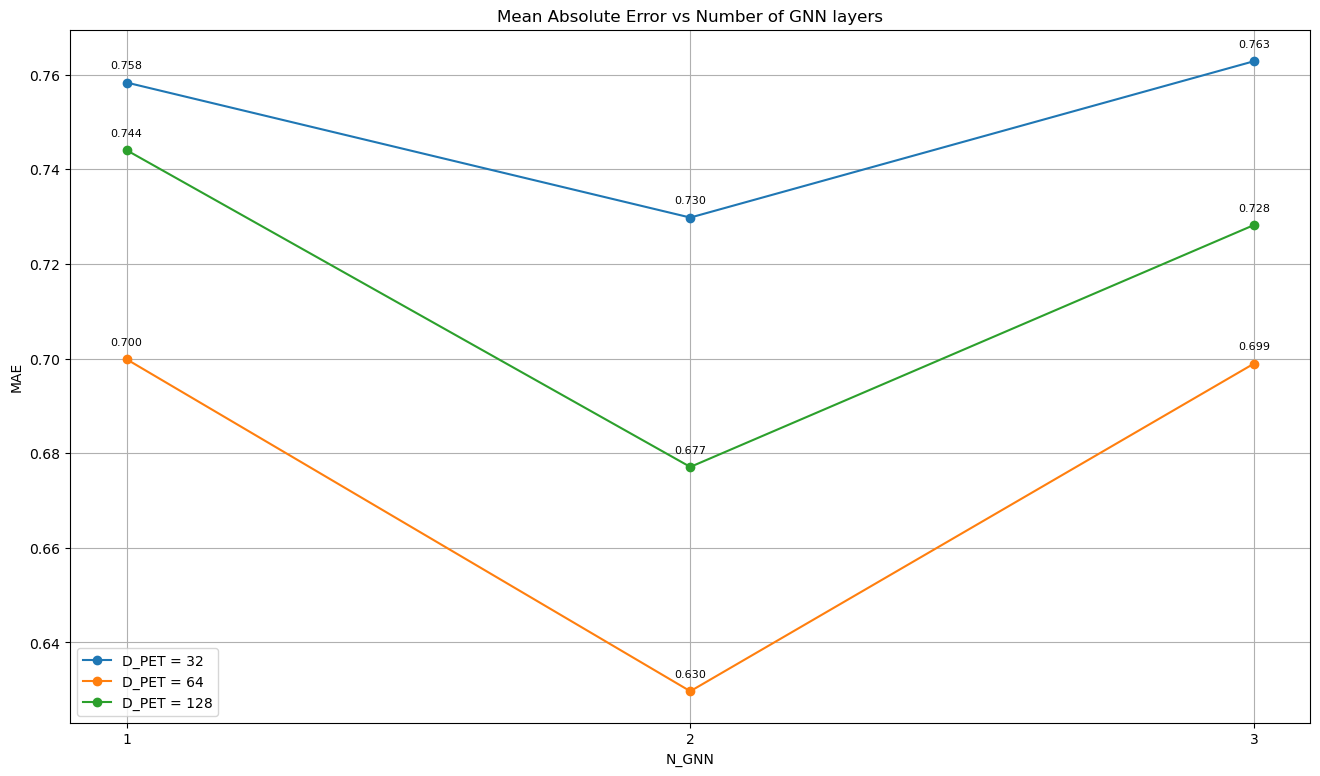

In [59]:
folders_32 = ["run_1_32", "run_2_32", "run_3_32"]
folders_64 = ["run_1_64", "run_2_64", "run_3_64"]
folders_128 = ["run_1_128", "run_2_128", "run_3_128"]

N_GNNs = [1, 2, 3]

best_maes_32 = get_best_maes(folders=folders_32, keys=N_GNNs)
best_maes_64 = get_best_maes(folders=folders_64, keys=N_GNNs)
best_maes_128 = get_best_maes(folders=folders_128, keys=N_GNNs)

x_values = list(best_maes_32.keys())
y_values_32 = list(best_maes_32.values())
y_values_64 = list(best_maes_64.values())
y_values_128 = list(best_maes_128.values())

plot(
    x_values,
    [y_values_32, y_values_64, y_values_128],
    ['D_PET = 32', 'D_PET = 64', 'D_PET = 128'],
    title="Mean Absolute Error vs Number of GNN layers",
    xlabel="N_GNN",
    ylabel="MAE"
)

### MAE vs D_PET

MAE is analysed against the dimentionality (`HEAD_N_NEURONS`, `TRANSFORMER_D_MODEL`) of the PET with a fixed number of GNN layers

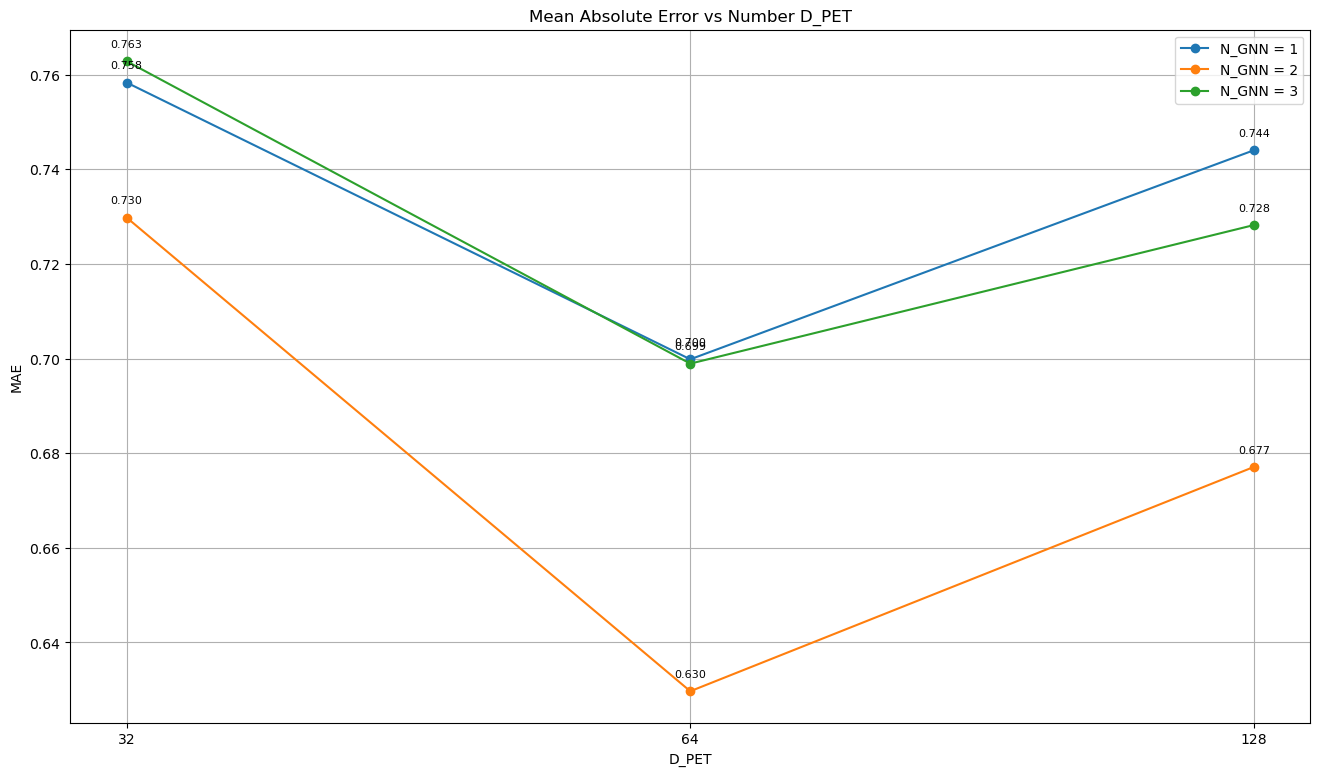

In [60]:
folders_n1 = ["run_1_32", "run_1_64", "run_1_128"]
folders_n2 = ["run_2_32", "run_2_64", "run_2_128"]
folders_n3 = ["run_3_32", "run_3_64", "run_3_128"]

D_PET = [32, 64, 128]

best_maes_n1 = get_best_maes(folders=folders_n1, keys=D_PET)
best_maes_n2 = get_best_maes(folders=folders_n2, keys=D_PET)
best_maes_n3 = get_best_maes(folders=folders_n3, keys=D_PET)

x_values = list(best_maes_n1.keys())
y_values_n1 = list(best_maes_n1.values())
y_values_n2 = list(best_maes_n2.values())
y_values_n3 = list(best_maes_n3.values())

plot(
    x_values,
    [y_values_n1, y_values_n2, y_values_n3],
    ['N_GNN = 1', 'N_GNN = 2', 'N_GNN = 3'],
    title="Mean Absolute Error vs Number D_PET",
    xlabel="D_PET",
    ylabel="MAE"
)

### Interference Times

Finally, we analyze the interference times from the output of running fitted PET models on the test structures. 

In [61]:
FOLDERS = ["run_1_32", "run_1_64", "run_1_128", "run_2_32", "run_2_64", "run_2_128", "run_3_32", "run_3_64", "run_3_128"]
KEYS = [
    "N_GNN 1, D_PET 32",
    "N_GNN 1, D_PET 64",
    "N_GNN 1, D_PET 128",
    "N_GNN 2, D_PET 32",
    "N_GNN 2, D_PET 64",
    "N_GNN 2, D_PET 128",
    "N_GNN 3, D_PET 32",
    "N_GNN 3, D_PET 64",
    "N_GNN 3, D_PET 128",
]

target_phrase_time = "approximate time per atom "
target_phrase_mae = "energies mae"

interference_times = {}
maes = {}

for index, folder in enumerate(FOLDERS):
    test_file_path = os.path.join(folder, "test.txt")

    if not os.path.isfile(test_file_path):
        print(f"File {test_file_path} not found")
        continue

    with open(test_file_path, "r") as file:
        for line in file:
            if target_phrase_mae in line:
                maes[KEYS[index]] = float(line.split()[-1].strip())

            if target_phrase_time in line:
                interference_times[KEYS[index]] = float(line.split()[-2].strip())


In [62]:
x_values = list(maes.values())
y_values = list(interference_times.values())

In [63]:
pairs = list(zip(x_values, y_values, maes.keys()))
pairs_sorted = sorted(pairs, key=lambda pair: pair[0])
x_values_sorted, y_values_sorted, sorted_keys = zip(*pairs_sorted)

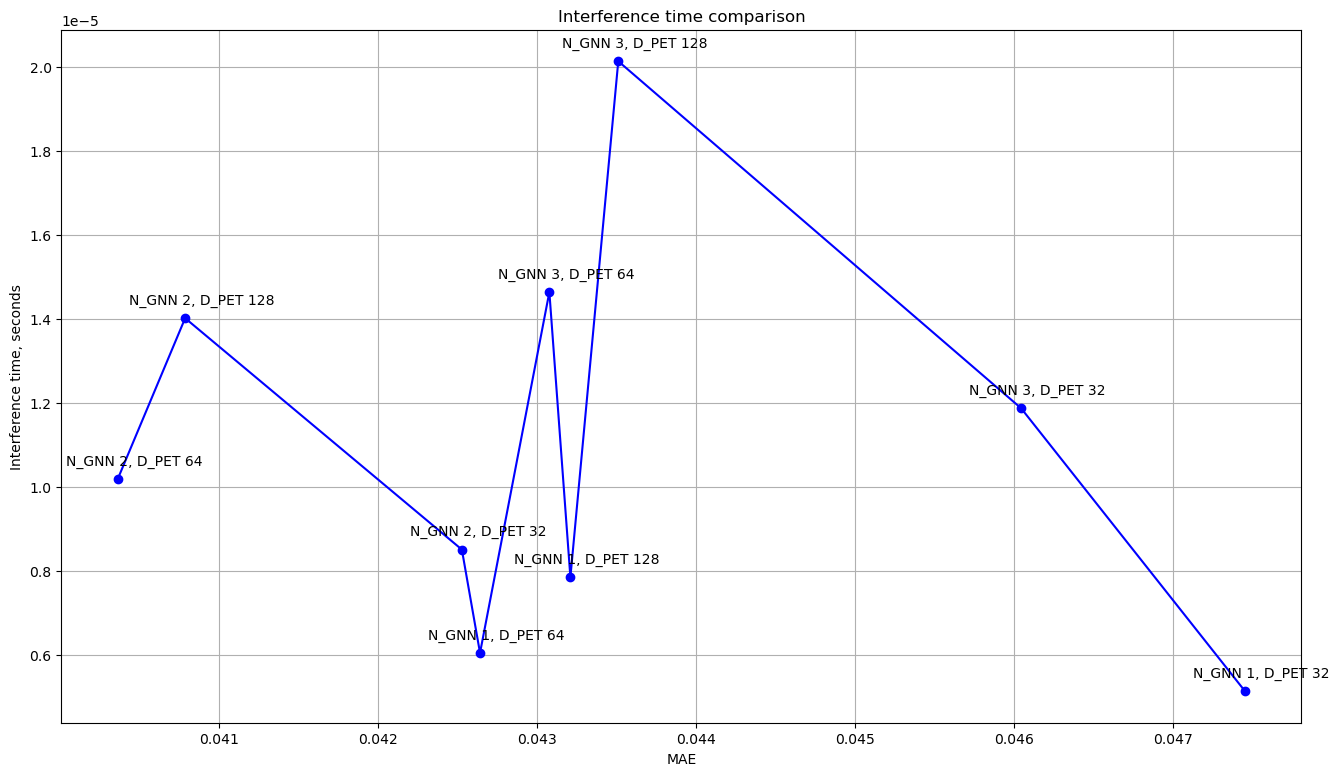

In [64]:
plt.figure(figsize=(16, 9))
plt.title("Interference time comparison")
plt.ylabel("Interference time, seconds")
plt.xlabel("MAE")
plt.plot(x_values_sorted, y_values_sorted, "bo-")

for index, (x, y) in enumerate(zip(list(x_values_sorted), list(y_values_sorted))):
    plt.annotate(
        f"{sorted_keys[index]}",
        (x, y),
        textcoords="offset points",
        xytext=(12, 10),
        ha="center",
    )

plt.grid(True)
plt.show()

### Learning Rates

In [65]:
def get_smooth(values, gamma):
    smoothed = []
    for i in range(len(values)):
        if i == 0:
            smoothed.append(values[i])
        else:
            smoothed.append(gamma * values[i] + (1 - gamma) * smoothed[i - 1])
    return smoothed

In [66]:
def present(ax, files, key, energy_key="energy"):
    ax.set_ylabel("mae")
    ax.set_xlabel("epoch")
    ax.set_title(key)

    for file in files:
        # Load history.pickle
        if not os.path.exists(f"{file}/history.pickle"):
            print(f"File {file}/history.pickle does not exist.")
            continue

        with open(f"{file}/history.pickle", "rb") as f:
            data = pickle.load(f)

        # Load continuation data
        i = 0
        while os.path.isdir(f"{file}_continuation_{i}"):
            continuation_path = f"{file}_continuation_{i}/history.pickle"
            if os.path.exists(continuation_path):
                with open(continuation_path, "rb") as f:
                    continuation_data = pickle.load(f)
                data.extend(continuation_data)
                i += 1
            else:
                break

        # Get data
        grid, val_mae, train_mae = [], [], []
        for idx, el in enumerate(data):
            grid.append(idx)
            val_mae.append(el[energy_key]["val"]["mae"])
            train_mae.append(el[energy_key]["train"]["mae"])

        smooth_val = get_smooth(val_mae, 0.7)
        smooth_train = get_smooth(train_mae, 0.7)

        # Statistics
        print()
        print(file)
        print("val min: ", np.min(val_mae))
        print("smooth val min: ", np.min(smooth_val))
        print("val last 500: ", np.mean(val_mae[-500:]))
        print("best val pos: ", np.argmin(val_mae) / len(val_mae))
        print("train min: ", np.min(train_mae))
        print("smooth train min: ", np.min(smooth_train))

        # Plots
        ax.plot(grid, smooth_val, label=f"val {np.min(val_mae):.2e}")
        ax.plot(grid, smooth_train, label=f"train {smooth_train[-1]:.2e}")

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
    ax.grid(True)

['./run_1_32/results/test']

./run_1_32/results/test
val min:  0.7583532746480425
smooth val min:  0.7589858874882416
val last 500:  0.7672768457502182
best val pos:  0.7744574884382782
train min:  0.0897111282717809
smooth train min:  0.09056859971697878
['./run_1_64/results/test']

./run_1_64/results/test
val min:  0.6998528671108901
smooth val min:  0.7036313243775006
val last 500:  0.718659899231905
best val pos:  0.5139372822299652
train min:  0.05606159051087173
smooth train min:  0.05683702190772946
['./run_1_128/results/test']

./run_1_128/results/test
val min:  0.7313318520832528
smooth val min:  0.7342617261520112
val last 500:  0.7493253800568773
best val pos:  0.5025281991443018
train min:  0.04730345925055338
smooth train min:  0.047930738546244946
['./run_2_32/results/test']

./run_2_32/results/test
val min:  0.7277044199203022
smooth val min:  0.728691327585014
val last 500:  0.736056582779647
best val pos:  0.8383720930232558
train min:  0.06935264394453834
smooth train

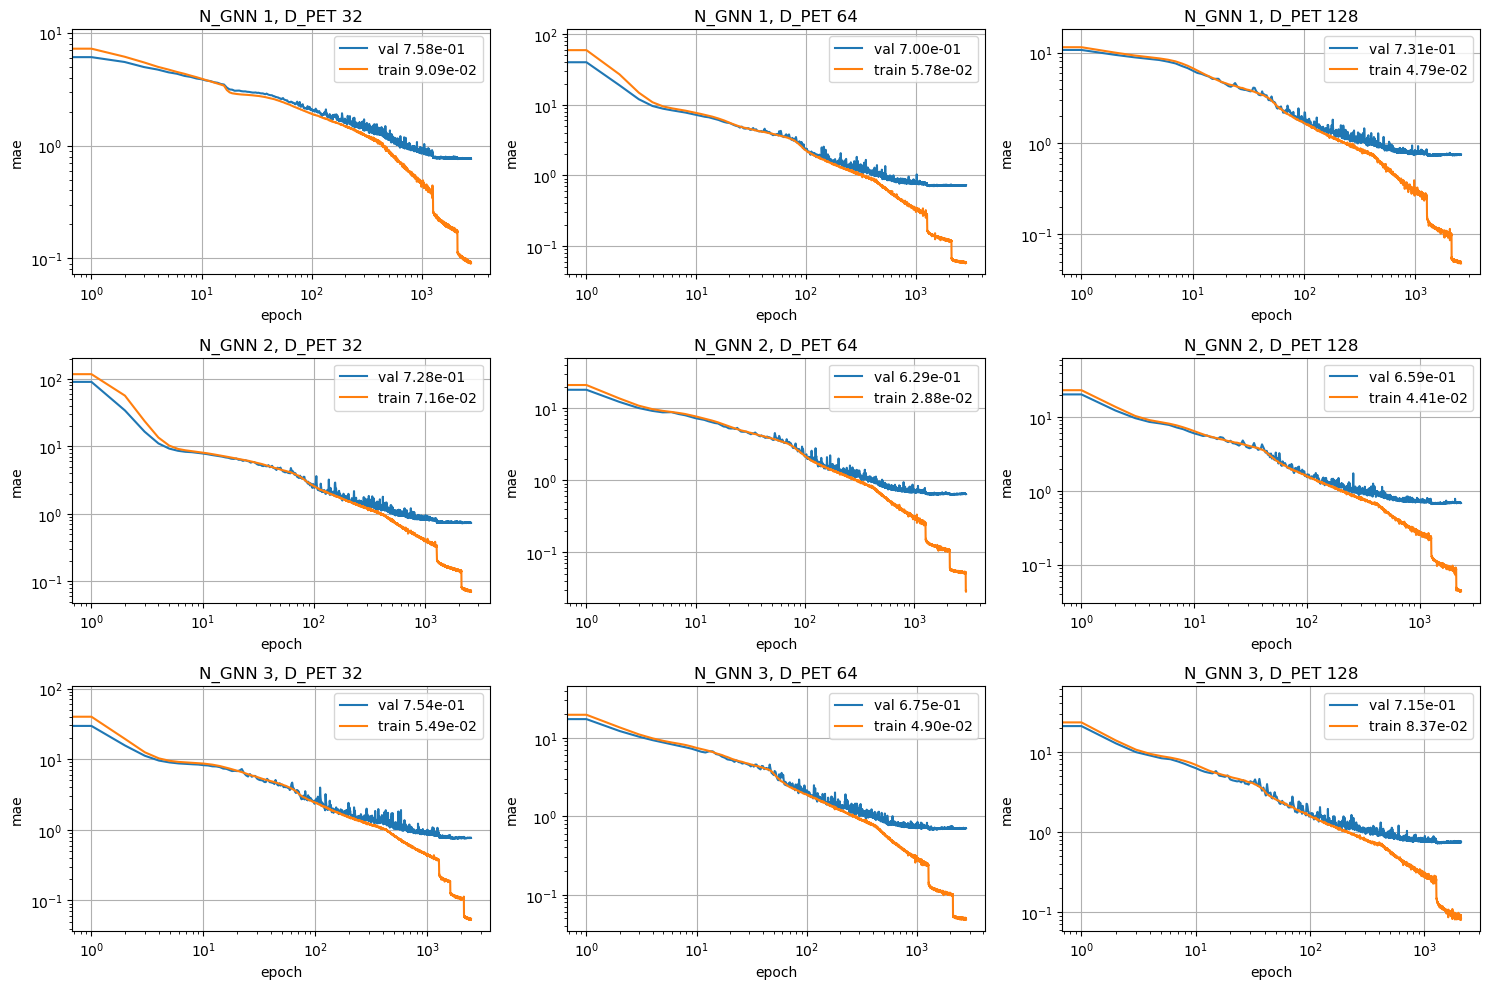

In [67]:
FOLDERS = ["run_1_32", "run_1_64", "run_1_128", "run_2_32", "run_2_64", "run_2_128", "run_3_32", "run_3_64", "run_3_128"]
KEYS = [
    "N_GNN 1, D_PET 32",
    "N_GNN 1, D_PET 64",
    "N_GNN 1, D_PET 128",
    "N_GNN 2, D_PET 32",
    "N_GNN 2, D_PET 64",
    "N_GNN 2, D_PET 128",
    "N_GNN 3, D_PET 32",
    "N_GNN 3, D_PET 64",
    "N_GNN 3, D_PET 128",
]

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, folder, key in zip(axes, FOLDERS, KEYS):
    FOLDER_PATH = f"./{folder}/results/"

    files = os.listdir(FOLDER_PATH)

    files = [FOLDER_PATH + file for file in files if not file.startswith(".")]
    files = [file for file in files if "continuation" not in file]
    print(files)

    present(ax, files, key, energy_key="energies per structure")

plt.tight_layout()
plt.show()